<a href="https://colab.research.google.com/github/sergekamanzi/Sound-Clustering-HMMs/blob/main/soundclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install librosa  plotly --quiet

In [3]:
from google.colab import files
uploaded = files.upload()

Saving unlabelled_sounds.zip to unlabelled_sounds.zip


**Extract Audio Files from Uploaded ZIP Archive**



In [4]:
import zipfile
import os
import librosa

zip_path = list(uploaded.keys())[0]  # gets the uploaded file name, e.g. 'sounds.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('sounds_folder')  # extracts to folder 'sounds_folder'

print("Files extracted to sounds_folder/")

Files extracted to sounds_folder/


 **Load and List Audio Files**

In [5]:
folder_path = '/content/sounds_folder/unlabelled_sounds'  # Change this to your folder path

# List all audio files (e.g., .wav, .mp3, .flac, .ogg)
audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.flac', '.ogg'))]

# Print total and sample files
print(f"Total audio files extracted: {len(audio_files)}")
print(f"Sample files: {audio_files[:10]}")

Total audio files extracted: 3000
Sample files: ['2698.wav', '2061.wav', '2418.wav', '909.wav', '750.wav', '1093.wav', '2101.wav', '599.wav', '2582.wav', '1415.wav']


**Initial Feature Visualization**

This provides a basic visualization of the extracted features by plotting the first two dimensions (features) for all audio samples.

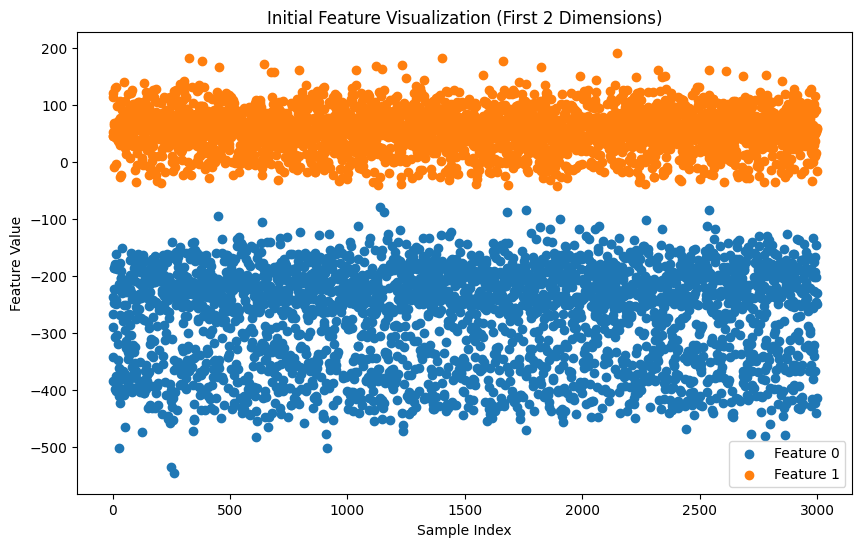

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initial visualization using pair plots (limited to first two dimensions due to high dimensionality)
plt.figure(figsize=(10, 6))
for i in range(min(2, features.shape[1])):
    plt.scatter(range(len(features)), features[:, i], label=f'Feature {i}')
plt.title("Initial Feature Visualization (First 2 Dimensions)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

**Extract MFCC Features from Audio Files**

This processes each audio file by loading it with its original sample rate and extracting 40 Mel-Frequency Cepstral Coefficients (MFCCs) as audio features. It stores the mean of each MFCC over time for consistency. Errors during processing are handled by inserting zero vectors. The result is a NumPy array containing feature vectors for each file.

In [8]:
%%capture
import numpy as np

features = []
sample_rate = None  # To store the sample rate of the first file

for i, file_name in enumerate(audio_files):
    file_path = os.path.join(folder_path, file_name)
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load audio file, preserving original sample rate
        if sample_rate is None:
            sample_rate = sr  # Store sample rate of the first file

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40) # You can adjust n_mfcc
        features.append(mfccs.mean(axis=1)) # Take the mean of MFCCs over time

        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{len(audio_files)} files")

    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
        features.append(np.zeros(40)) # Append zero vector for problematic files


features = np.array(features)
print("\nFeature extraction complete.")
print(f"Shape of features array: {features.shape}")

**Dimensionality Reduction and 3D Visualization (PCA & t-SNE)**

PCA (Principal Component Analysis): A linear method that captures the directions of maximum variance.

t-SNE (t-Distributed Stochastic Neighbor Embedding): A non-linear method that preserves local structure in data.

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

# t-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(features)

# 3D Visualization
fig_pca = px.scatter_3d(x=pca_result[:, 0], y=pca_result[:, 1], z=pca_result[:, 2], title="PCA 3D Visualization")
fig_tsne = px.scatter_3d(x=tsne_result[:, 0], y=tsne_result[:, 1], z=tsne_result[:, 2], title="t-SNE 3D Visualization")
fig_pca.show()
fig_tsne.show()

**Clustering with K-Means and DBSCAN + Evaluation Metrics**

K-Means Clustering:

-Uses the Elbow Method (inertia) and Silhouette Score to determine the optimal number of clusters.


DBSCAN (Density-Based Spatial Clustering):

-Groups points based on density without requiring the number of clusters to be specified.

In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Elbow Method and Silhouette Score for K-Means
inertia = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_result, kmeans.labels_))

# Optimal K
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_result)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_result)

Optimal number of clusters: 2


**Cluster Evaluation Metrics & Visualization (K-Means vs DBSCAN)**

This cell evaluates and visualizes the clustering results from both K-Means and DBSCAN using:

-Silhouette Score: Measures how well samples are clustered with similar ones.

-Davies-Bouldin Index: Evaluates intra-cluster similarity and inter-cluster differences (lower is better).

-Inertia (for K-Means): Sum of squared distances from samples to their closest cluster center.

K-Means Inertia: 13466932.0, Silhouette Score: 0.49686548113822937, Davies-Bouldin Index: 0.7570272242156486
DBSCAN Silhouette Score: -1, Davies-Bouldin Index: -1


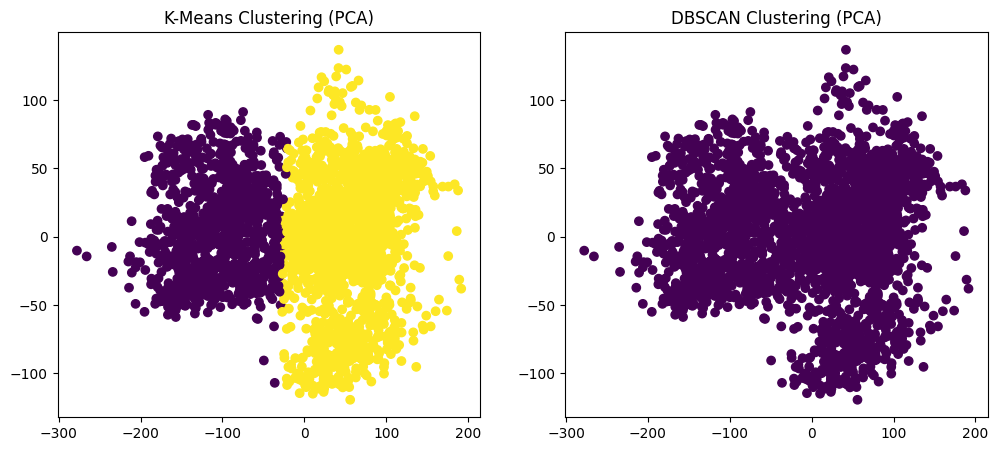

In [12]:
# Cluster compactness and separation metrics
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(pca_result, kmeans_labels)
kmeans_db_index = davies_bouldin_score(pca_result, kmeans_labels)
dbscan_silhouette = silhouette_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1
dbscan_db_index = davies_bouldin_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1

print(f"K-Means Inertia: {kmeans_inertia}, Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db_index}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Index: {dbscan_db_index}")

# Visual Interpretability
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clustering (PCA)")
plt.subplot(1, 2, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clustering (PCA)")
plt.show()

**Cluster Evaluation Summary & Visual Comparison (K-Means vs DBSCAN)**

Compactness & Separation Metrics:

Inertia, Silhouette Score, and Davies-Bouldin Index help evaluate how well the clusters are formed.

Diagnostic Plots:

Elbow Curve: Shows how inertia decreases with more clusters (K) to help choose the optimal K.

Silhouette Score Plot: Displays how the average silhouette score changes with K.

Combined 2D Visualization: Overlays K-Means and DBSCAN clustering results on a PCA-reduced 2D space to visually compare how each algorithm separates the data.

K-Means Inertia: 13466932.0, Silhouette Score: 0.49686548113822937, Davies-Bouldin Index: 0.7570272242156486
DBSCAN Silhouette Score: -1, Davies-Bouldin Index: -1


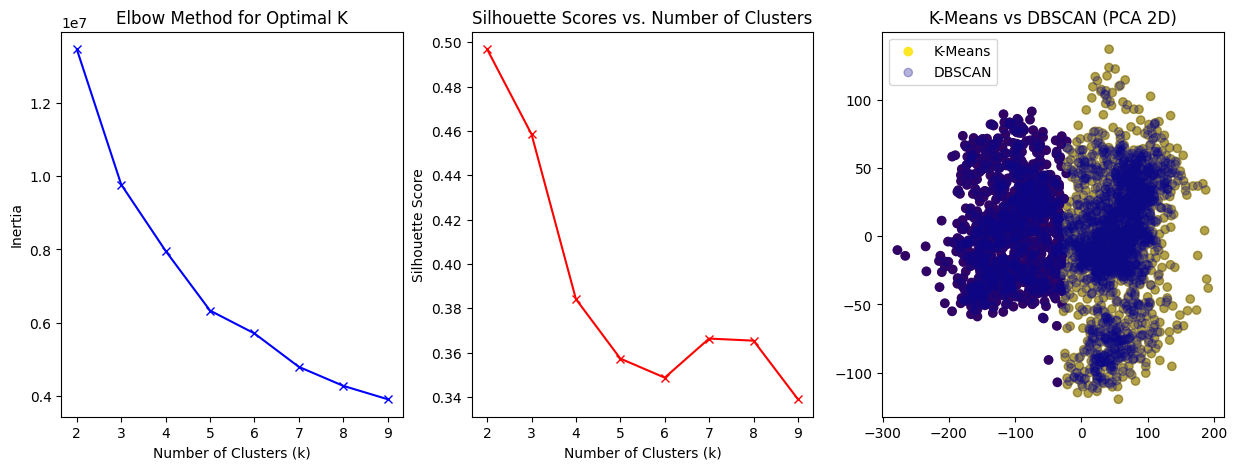

In [13]:
# Cluster compactness and separation metrics
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(pca_result, kmeans_labels)
kmeans_db_index = davies_bouldin_score(pca_result, kmeans_labels)
dbscan_silhouette = silhouette_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1
dbscan_db_index = davies_bouldin_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1

print(f"K-Means Inertia: {kmeans_inertia}, Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db_index}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Index: {dbscan_db_index}")

# Additional Plots
plt.figure(figsize=(15, 5))

# Plot 1: Elbow Curve
plt.subplot(1, 3, 1)
plt.plot(K, inertia, 'bx-')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

# Plot 2: Silhouette Scores
plt.subplot(1, 3, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.title("Silhouette Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

# Plot 3: 2D Clustering Visualization
plt.subplot(1, 3, 3)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', label='K-Means')
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.3, label='DBSCAN')
plt.title("K-Means vs DBSCAN (PCA 2D)")
plt.legend()
plt.show()

**Using Hidden Markov Model (HMM) for Home Energy Consumption Analysis**


---


**1. Observations**: The HMM would use measurable data such as time-series power consumption readings (in watts or kilowatt-hours) from smart meters or IoT sensors attached to household appliances (e.g., fridge, TV, washing machine). Additional observations could include timestamped usage patterns (e.g., on/off states, duration of use) and environmental factors like time of day or temperature, which influence appliance usage.


---



**2. Type of HMM Problem**: Since the hidden states (e.g., specific appliances or their operational modes like "on," "off," or "standby") are not known in advance and must be inferred from the data, this is a learning problem (unsupervised HMM). The model identifies hidden states and their transitions from observed power consumption patterns.



---



**3. Training Algorithm**:

  **a. Known Values at Start**: The observed data (power consumption readings, usage durations, and contextual factors like time) and the number of hidden states (e.g., estimated number of appliances or modes) are known. Initial guesses for model parameters (e.g., random transition and emission probabilities) are also set.

 **b. Unknown Values to be Learned**: The hidden states (e.g., which appliance or mode corresponds to each state), transition probabilities (likelihood of switching between states, e.g., fridge "on" to "off"), and emission probabilities (likelihood of observed power readings given a state, e.g., TV "on" emits ~100W) need to be learned.



---



**4.Parameter Updates**: The training algorithm (Baum-Welch algorithm) will update:

**a.Transition probabilities**: Probabilities of moving between hidden states (e.g., appliance switching from "on" to "standby").

**b.Emission probabilities**: Probabilities of observing specific power consumption values for each hidden state (e.g., fridge "on" state emitting ~150W).

**c.Initial state probabilities**: Likelihood of starting in a particular hidden state (e.g., TV "off" at the beginning of the day).